In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path="/content/drive/MyDrive/Research/Hard_Attention/dataset_2/m_5_size_100/run_"

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/hard_attention')

# Generate dataset

In [5]:
np.random.seed(1)

y = np.concatenate((np.zeros(500),np.ones(500),np.ones(500)*2,np.ones(500)*3,np.ones(500)*4,
                    np.ones(500)*5,np.ones(500)*6,np.ones(500)*7,np.ones(500)*8,np.ones(500)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [6]:
x = np.zeros((5000,2))

In [7]:
x = np.zeros((5000,2))


np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [5,5],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

In [8]:
x[idx[0]][0], x[idx[2]][5] 

(array([5.14957125, 4.78451422]), array([5.59513544, 6.5252764 ]))

In [9]:
print(x.shape,y.shape)

(5000, 2) (5000,)


In [10]:
idx= []
for i in range(10):
  idx.append(y==i)

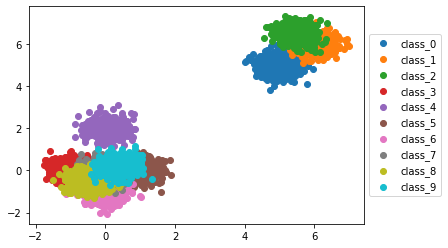

In [11]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
x = ( x -  np.mean(x,axis=0,keepdims=True) ) / np.std(x,axis=0,keepdims=True) 


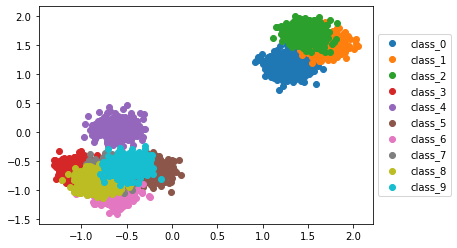

In [13]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [15]:
desired_num = 1500
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 100
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1500/1500 [00:02<00:00, 631.21it/s]


In [16]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [17]:
len(mosaic_list_of_images), mosaic_list_of_images[0],mosaic_list_of_images[0].shape

(1500,
 array([[-0.59356559, -0.77464016],
        [-0.57790426, -1.12507041],
        [-0.50120586, -1.10130896],
        [-0.85061921,  0.02673107],
        [-0.83096682, -0.93025336],
        [-0.94404393, -0.55234797],
        [-0.52791954, -0.53956741],
        [-1.0399314 , -0.53913493],
        [-0.34157373, -0.44551072],
        [-0.58416129, -0.66457382],
        [-0.6128801 , -0.54003195],
        [-0.84543321, -0.07104247],
        [-0.48987901, -0.03513917],
        [-1.13264329, -0.80000207],
        [-0.61164105, -0.51718797],
        [-0.92553537, -0.5648187 ],
        [-0.6441374 , -0.64752999],
        [-0.97349118, -0.62245347],
        [-0.55912811, -0.74892406],
        [-0.84205538,  0.04121291],
        [-0.63315146, -0.90570363],
        [-0.49828168, -1.19502388],
        [-0.99393076, -0.84662554],
        [-0.76422982,  0.1050219 ],
        [-1.14436649, -0.5901262 ],
        [-0.33898115, -0.51546809],
        [-0.56105709, -1.1784382 ],
        [-0.2349192 ,

In [18]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [19]:
batch = 50
msd1 = MosaicDataset(mosaic_list_of_images[0:500], mosaic_label[0:500] , fore_idx[0:500])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [20]:
data,_,_=iter(train_loader).next()

In [21]:
data.shape

torch.Size([50, 100, 2])

In [22]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[500:], mosaic_label[500:] , fore_idx[500:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [23]:
class Focus(nn.Module):
    def __init__(self):
        super(Focus, self).__init__()
        self.fc1 = nn.Linear(2,1, bias=False)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        #self.fc2 = nn.Linear(64, 1, bias=False)
        #torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self,z):
        #print("data",z)
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)

        alpha = F.softmax(alp1,dim=1)
        #print(self.training)
        
        if self.training:
            alpha =alpha[:,:,0]
            y = ft1 
            return alpha,y
        else:
            #alpha_cumsum = torch.cumsum(alpha, dim = 1)
            #print(alpha_cumsum)
            #len_batch = alpha_cumsum.size(0)
            #patches = alpha_cumsum.size(1)
            #rand_prob = torch.rand(len_batch,patches, 1).to(device)
            #alpha_relu = F.relu(rand_prob-alpha_cumsum)
            #print(alpha_relu)
            #alpha_index = torch.count_nonzero(alpha_relu,dim=1)
            #alpha_hard = F.one_hot(alpha_index,num_classes=patches)
            #print(alpha_hard)
            #alpha_hard = torch.transpose(alpha_hard,dim0=1,dim1=2)
            #print(ft1,"alpha_hard",alpha_hard) 
            #y = torch.sum(alpha_hard*ft1,dim=1)
            #print(alpha,alpha.shape)
         
        
            index = torch.argmax(alpha,dim=1)
            hard_alpha = torch.nn.functional.one_hot(index[:,0], patches)
            y = torch.sum(hard_alpha[:,:,None]*ft1,dim=1)
            alpha = alpha[:,:,0]
            return alpha,y
    
    def helper(self, x):
        x1 = x
        x = self.fc1(x)
        return x,x1

In [24]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)

  def forward(self, x):
    #print(x.shape)
    #x = x.view(-1, 1)
    #print(x.shape)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [25]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to(device)

In [26]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to(device)

In [27]:
import torch.optim as optim
optimizer_classify = optim.Adam(classify.parameters(), lr=0.1 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.1 ) #, momentum=0.9)

In [28]:
def my_cross_entropy(output,target,alpha):
    criterion = nn.CrossEntropyLoss(reduce=False)
    
    batch = output.size(0)
    #print(batch)
    patches = output.size(1)
    classes = output.size(2)
    
    
    
    output = torch.reshape(output,(batch*patches,classes))
    
    
    target = target.repeat_interleave(patches)
    
    loss = criterion(output,target)
    
    #print(loss,loss.shape)
    loss = torch.reshape(loss,(batch,patches))
    #print(loss.size())
    final_loss = torch.sum(torch.mul(loss,alpha),dim=1)
    #print(final_loss.shape)
    final_loss = torch.mean(final_loss,dim=0)
    
    
    
    #print(final_loss)
    return final_loss
    
    
    

In [29]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [30]:
def plot_attended_data(trainloader,net,epoch):
    attd_data =[]
    lbls = []
    for data in trainloader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
        alphas, avg_images = focus_net(inputs)
        attd_data.append(avg_images.numpy())
        lbls.append(labels)
    attd_data = np.concatenate(attd_data,axis=0)
    lbls = np.concatenate(lbls,axis=0)
    plt.figure(figsize=(6,8))
    plt.scatter(attd_data[:,0],attd_data[:,1],c=lbls)
    plt.title("EPOCH_"+str(epoch))

In [31]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    loss = my_cross_entropy(outputs,labels,alphas)
    print(loss)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)


print("="*100)



tensor(1.1547, dtype=torch.float64)
tensor(1.1210, dtype=torch.float64)
tensor(1.1504, dtype=torch.float64)
tensor(1.1238, dtype=torch.float64)
tensor(1.1474, dtype=torch.float64)
tensor(1.1527, dtype=torch.float64)
tensor(1.1346, dtype=torch.float64)
tensor(1.1287, dtype=torch.float64)
tensor(1.1638, dtype=torch.float64)
tensor(1.1133, dtype=torch.float64)


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [32]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)


In [33]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[-0.4664, -0.4478]], dtype=torch.float64, requires_grad=True))


In [34]:
nos_epochs = 2000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    batch = inputs.size(0)
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = my_cross_entropy(outputs, labels,alphas) 
    
    loss.backward()
    
    
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 10
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1

  if(np.mean(epoch_loss) <= 0.01):
      break;
  #plot_attended_data(train_loader,focus_net,epoch)

    
print('Finished Training')

[1,    10] loss: 1.133
[2,    10] loss: 1.116
[3,    10] loss: 1.105
[4,    10] loss: 1.089
[5,    10] loss: 1.041
[6,    10] loss: 0.999
[7,    10] loss: 0.936
[8,    10] loss: 0.904
[9,    10] loss: 0.839
[10,    10] loss: 0.795
[11,    10] loss: 0.757
[12,    10] loss: 0.726
[13,    10] loss: 0.696
[14,    10] loss: 0.663
[15,    10] loss: 0.641
[16,    10] loss: 0.617
[17,    10] loss: 0.601
[18,    10] loss: 0.580
[19,    10] loss: 0.569
[20,    10] loss: 0.557
[21,    10] loss: 0.537
[22,    10] loss: 0.520
[23,    10] loss: 0.515
[24,    10] loss: 0.504
[25,    10] loss: 0.500
[26,    10] loss: 0.485
[27,    10] loss: 0.475
[28,    10] loss: 0.476
[29,    10] loss: 0.464
[30,    10] loss: 0.452
[31,    10] loss: 0.449
[32,    10] loss: 0.437
[33,    10] loss: 0.428
[34,    10] loss: 0.426
[35,    10] loss: 0.417
[36,    10] loss: 0.412
[37,    10] loss: 0.408
[38,    10] loss: 0.407
[39,    10] loss: 0.419
[40,    10] loss: 0.396
[41,    10] loss: 0.398
[42,    10] loss: 0.402
[

[337,    10] loss: 0.252
[338,    10] loss: 0.254
[339,    10] loss: 0.253
[340,    10] loss: 0.251
[341,    10] loss: 0.254
[342,    10] loss: 0.277
[343,    10] loss: 0.260
[344,    10] loss: 0.256
[345,    10] loss: 0.250
[346,    10] loss: 0.251
[347,    10] loss: 0.251
[348,    10] loss: 0.249
[349,    10] loss: 0.257
[350,    10] loss: 0.248
[351,    10] loss: 0.254
[352,    10] loss: 0.262
[353,    10] loss: 0.249
[354,    10] loss: 0.250
[355,    10] loss: 0.252
[356,    10] loss: 0.271
[357,    10] loss: 0.263
[358,    10] loss: 0.260
[359,    10] loss: 0.251
[360,    10] loss: 0.252
[361,    10] loss: 0.258
[362,    10] loss: 0.248
[363,    10] loss: 0.250
[364,    10] loss: 0.251
[365,    10] loss: 0.263
[366,    10] loss: 0.249
[367,    10] loss: 0.273
[368,    10] loss: 0.252
[369,    10] loss: 0.251
[370,    10] loss: 0.265
[371,    10] loss: 0.268
[372,    10] loss: 0.252
[373,    10] loss: 0.255
[374,    10] loss: 0.260
[375,    10] loss: 0.255
[376,    10] loss: 0.254


[665,    10] loss: 0.250
[666,    10] loss: 0.253
[667,    10] loss: 0.249
[668,    10] loss: 0.253
[669,    10] loss: 0.241
[670,    10] loss: 0.243
[671,    10] loss: 0.239
[672,    10] loss: 0.241
[673,    10] loss: 0.245
[674,    10] loss: 0.243
[675,    10] loss: 0.247
[676,    10] loss: 0.244
[677,    10] loss: 0.240
[678,    10] loss: 0.240
[679,    10] loss: 0.247
[680,    10] loss: 0.244
[681,    10] loss: 0.246
[682,    10] loss: 0.247
[683,    10] loss: 0.244
[684,    10] loss: 0.240
[685,    10] loss: 0.246
[686,    10] loss: 0.241
[687,    10] loss: 0.243
[688,    10] loss: 0.243
[689,    10] loss: 0.250
[690,    10] loss: 0.253
[691,    10] loss: 0.246
[692,    10] loss: 0.242
[693,    10] loss: 0.241
[694,    10] loss: 0.244
[695,    10] loss: 0.240
[696,    10] loss: 0.249
[697,    10] loss: 0.243
[698,    10] loss: 0.243
[699,    10] loss: 0.242
[700,    10] loss: 0.248
[701,    10] loss: 0.247
[702,    10] loss: 0.257
[703,    10] loss: 0.240
[704,    10] loss: 0.242


[1002,    10] loss: 0.252
[1003,    10] loss: 0.251
[1004,    10] loss: 0.240
[1005,    10] loss: 0.240
[1006,    10] loss: 0.239
[1007,    10] loss: 0.239
[1008,    10] loss: 0.243
[1009,    10] loss: 0.239
[1010,    10] loss: 0.241
[1011,    10] loss: 0.245
[1012,    10] loss: 0.241
[1013,    10] loss: 0.238
[1014,    10] loss: 0.240
[1015,    10] loss: 0.240
[1016,    10] loss: 0.239
[1017,    10] loss: 0.242
[1018,    10] loss: 0.248
[1019,    10] loss: 0.244
[1020,    10] loss: 0.238
[1021,    10] loss: 0.243
[1022,    10] loss: 0.240
[1023,    10] loss: 0.241
[1024,    10] loss: 0.239
[1025,    10] loss: 0.238
[1026,    10] loss: 0.242
[1027,    10] loss: 0.240
[1028,    10] loss: 0.265
[1029,    10] loss: 0.237
[1030,    10] loss: 0.240
[1031,    10] loss: 0.240
[1032,    10] loss: 0.245
[1033,    10] loss: 0.239
[1034,    10] loss: 0.242
[1035,    10] loss: 0.242
[1036,    10] loss: 0.239
[1037,    10] loss: 0.242
[1038,    10] loss: 0.247
[1039,    10] loss: 0.249
[1040,    10

[1321,    10] loss: 0.241
[1322,    10] loss: 0.237
[1323,    10] loss: 0.237
[1324,    10] loss: 0.240
[1325,    10] loss: 0.244
[1326,    10] loss: 0.240
[1327,    10] loss: 0.242
[1328,    10] loss: 0.242
[1329,    10] loss: 0.240
[1330,    10] loss: 0.241
[1331,    10] loss: 0.248
[1332,    10] loss: 0.240
[1333,    10] loss: 0.244
[1334,    10] loss: 0.244
[1335,    10] loss: 0.249
[1336,    10] loss: 0.244
[1337,    10] loss: 0.244
[1338,    10] loss: 0.248
[1339,    10] loss: 0.245
[1340,    10] loss: 0.237
[1341,    10] loss: 0.238
[1342,    10] loss: 0.240
[1343,    10] loss: 0.238
[1344,    10] loss: 0.237
[1345,    10] loss: 0.240
[1346,    10] loss: 0.239
[1347,    10] loss: 0.248
[1348,    10] loss: 0.238
[1349,    10] loss: 0.244
[1350,    10] loss: 0.240
[1351,    10] loss: 0.245
[1352,    10] loss: 0.244
[1353,    10] loss: 0.239
[1354,    10] loss: 0.240
[1355,    10] loss: 0.240
[1356,    10] loss: 0.242
[1357,    10] loss: 0.237
[1358,    10] loss: 0.239
[1359,    10

[1646,    10] loss: 0.239
[1647,    10] loss: 0.238
[1648,    10] loss: 0.243
[1649,    10] loss: 0.254
[1650,    10] loss: 0.244
[1651,    10] loss: 0.242
[1652,    10] loss: 0.246
[1653,    10] loss: 0.261
[1654,    10] loss: 0.256
[1655,    10] loss: 0.244
[1656,    10] loss: 0.249
[1657,    10] loss: 0.247
[1658,    10] loss: 0.243
[1659,    10] loss: 0.249
[1660,    10] loss: 0.242
[1661,    10] loss: 0.239
[1662,    10] loss: 0.238
[1663,    10] loss: 0.243
[1664,    10] loss: 0.247
[1665,    10] loss: 0.238
[1666,    10] loss: 0.239
[1667,    10] loss: 0.238
[1668,    10] loss: 0.237
[1669,    10] loss: 0.236
[1670,    10] loss: 0.236
[1671,    10] loss: 0.240
[1672,    10] loss: 0.236
[1673,    10] loss: 0.237
[1674,    10] loss: 0.237
[1675,    10] loss: 0.245
[1676,    10] loss: 0.240
[1677,    10] loss: 0.250
[1678,    10] loss: 0.239
[1679,    10] loss: 0.239
[1680,    10] loss: 0.238
[1681,    10] loss: 0.240
[1682,    10] loss: 0.239
[1683,    10] loss: 0.243
[1684,    10

[1966,    10] loss: 0.237
[1967,    10] loss: 0.245
[1968,    10] loss: 0.239
[1969,    10] loss: 0.239
[1970,    10] loss: 0.245
[1971,    10] loss: 0.242
[1972,    10] loss: 0.259
[1973,    10] loss: 0.239
[1974,    10] loss: 0.254
[1975,    10] loss: 0.246
[1976,    10] loss: 0.237
[1977,    10] loss: 0.240
[1978,    10] loss: 0.241
[1979,    10] loss: 0.241
[1980,    10] loss: 0.246
[1981,    10] loss: 0.252
[1982,    10] loss: 0.235
[1983,    10] loss: 0.243
[1984,    10] loss: 0.240
[1985,    10] loss: 0.241
[1986,    10] loss: 0.238
[1987,    10] loss: 0.238
[1988,    10] loss: 0.242
[1989,    10] loss: 0.248
[1990,    10] loss: 0.255
[1991,    10] loss: 0.244
[1992,    10] loss: 0.241
[1993,    10] loss: 0.244
[1994,    10] loss: 0.247
[1995,    10] loss: 0.240
[1996,    10] loss: 0.243
[1997,    10] loss: 0.239
[1998,    10] loss: 0.238
[1999,    10] loss: 0.242
[2000,    10] loss: 0.249
Finished Training


In [35]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[8.9509, 7.3677]], dtype=torch.float64, requires_grad=True))


In [36]:
correct = 0
total = 0

focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    #print(outputs.shape)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the train images: 89.600000 %
total correct 448
total train set images 500


In [37]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the test images: 89.200000 %
total correct 892
total train set images 1000
